/usr/local/lib/python2.7/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:74: UserWarning: Low image dynamic range; displaying image with stretched contrast.
  warn("Low image dynamic range; displaying image with "


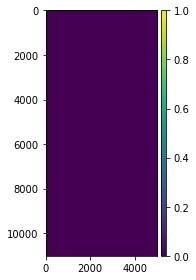

In [2]:
'''
Takes in heatmap of lymph node produced by NN and predicts metastasis class
Must classify each "blob"
Metastasis classes for lymph nodes:
    negative: no tumor cells
    itc: single tumor cell or cluster < 0.2 mm or less than 200 cells
    micro: 0.2 mm or more than 200 cells but < 2.0 mm
    macro: greater than 2.0 mm

Patient classes:
    pN0: No micro-metastases or macro-metastases or ITCs found.
    pN0(i+): Only ITCs found.
    pN1mi: Micro-metastases found, but no macro-metastases found.
    pN1: Metastases found in 1–3 lymph nodes, of which at least one is a macro-metastasis.
    pN2: Metastases found in 4–9 lymph nodes, of which at least one is a macro-metastasis.
    
Takes in a directory of heat maps: 1-channel

blob feature ideas:
    cell count: can't do without original image
    % of tumor over whole tissue region
    % of tumor over surrouding convex region (blob)
    average prediction values over tumor
    variance of prediction values 
    longest axis of tumor
    
'''

import multiresolutionimageinterface as mir
from skimage import io, exposure
from skimage.morphology import binary_dilation, remove_small_objects, remove_small_holes
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from skimage.filters import threshold_otsu, roberts, sobel
from skimage.color import rgb2gray
from skimage.feature import canny, blob_dog
from skimage.measure import regionprops, label
from skimage.exposure import equalize_adapthist
from os import listdir
from os.path import isfile, join, basename
import time
import os, sys
from openslide import OpenSlide
import argparse
from skimage.data import binary_blobs
from math import sqrt

THRESHOLDS = [0.45, 0.5, 0.55, 0.6]
RMV_SIZES = [50, 60, 70, 80]
#returns the count of small objects 
def cell_counter(img, clip_limit, thresh, rmv_size, rmv_connectivity):
    #increase contrast
    img = equalize_adapthist(img, kernel_size = (50,50), clip_limit = clip_limit)
    gray_img = rgb2gray(img)
    binary = gray_img > thresh
    binary = remove_small_objects(binary, min_size=rmv_size, connectivity=rmv_connectivity)
    all_labels, num = measure.label(binary,return_num=True,background=0)
    return num

def max_distance():
    pass

def get_arguments():
    parser=argparse.ArgumentParser(description='takes a directory of heatmaps and predicts lymph node classes')
    parser.add_argument('--heatmapdir',type=str,default='/home/kenleejr92/Desktop/heatmaps',
                       help='directory containing heatmaps.\
                        Program assumes all tif files within are either \
                        mask, input, or output files')
    return parser.parse_args()

def sample_window(mr_image, pixel, window_size, sampling_level):
    x, y = pixel
    if(y-window_size/2 < 0) or (x-window_size/2 < 0):
        return None
    else:
        sample_300x300 = mr_image.getUCharPatch(y-window_size/2,\
                                                x-window_size/2,\
                                                window_size,window_size,\
                                                sampling_level)
        return sample_300x300

def create_blob_feature_vector(blob):
    cell_counts = []
    for t in THRESHOLDS:
        for rmv_size in RMV_SIZES:
            num = cell_counter(blob, 0.5, t, rmv_size ,2)
            cell_counts.append(num)



def train_RF(heatmapdir='/media/kenleejr92/Untitled1/CAMELYON_2017/heatmaps',gtfile='/media/kenleejr92/stage_labels.csv'):
    '''
    This takes in directory of heatmaps and .csv of ground truth lymph node classes,
    creates features for each heatmap. It then trains a random forest classifier on the features
    Parameters: probability threshold, area threshold
    '''
    threshold = 2.5
    onlyfiles = [heatmapdir+'/'+f for f in listdir(heatmapdir) if (isfile(join(heatmapdir, f)) and f.endswith('.tif'))]
    for img in onlyfiles:
        heatmap = io.imread(img) 
        #threshold by probability
        positives = np.array(heatmap > threshold, dtype=np.int)
        #get connected regions
        labeled_connective_regions, num = label(positives,return_num=True,background=0,connectivity=2)
        #get features of all connected regions, and take only largest one
        regions = regionprops(labeled_connective_regions,heatmap)
        max_region = 0
        max_idx = 0 
        for idx,region in enumerate(regions):
            if region['area'] > max_region: 
                max_region = region['area']
                max_idx = idx
        largest_connective_region = np.array(labeled_connective_regions == idx, dtype=np.int)
        io.imshow(largest_connective_region)
        io.show()
# #         for prop in region:
# #             print(prop,region[prop])
#         io.imshow(img)
#         io.show()
#         io.imshow(region['filled_image'])
#         io.show()
        
def predict_RF(heatmapdir='/media/kenleejr92/Untitled1/CAMELYON_2017/heatmaps'):
    '''
    This takes in directory of heatmaps and predicts lymph node classes using a trained random forest classifier,
    producing a .csv of predicted lymph node classes
    '''
    #file to add predicted lymph node classes to
    f = open(heatmapdir+'/lymph_node_classes.csv','w+')
# if __name__ == '__main__':
#     args=get_arguments()
#     kwargs= vars(args)
#     pred_lymph_node_class( **kwargs)

train_RF()
